## Plot + Explore: Geometric Structure Variants

This notebook loads saved `*.npz` activations from `outputs/geometric_structure/` (produced by `260203_geometric_structure.ipynb`) and recomputes speaker separability metrics across **models × corruption variants × layers × token positions**.

**Notes**
- This is *post-hoc* analysis only (no model forward passes).
- `SUMMARY.json` is the source of truth for available models/variants + file paths.


In [7]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
import json
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


BASE_DIR = Path("outputs/geometric_structure")
SUMMARY_PATH = BASE_DIR / "SUMMARY.json"

assert SUMMARY_PATH.exists(), f"Missing {SUMMARY_PATH.resolve()}"

In [8]:
with SUMMARY_PATH.open("r") as f:
    summary = json.load(f)

models = sorted(summary.keys())
variants = sorted({v for m in summary.values() for v in m.keys()})

print("models:", models)
print("num variants:", len(variants))
print("variants:", variants)

models: ['llama_3_1_8b', 'qwen_2_5', 'qwen_7b']
num variants: 10
variants: ['baseline', 'mask_name_tags', 'mask_verbs', 'only_function_words', 'only_verbs', 'replace_verbs_random', 'speaker_label_shuffle', 'strip_name_tags', 'turn_shuffle_within_dialogue', 'turn_shuffle_within_speaker']


In [9]:
@dataclass(frozen=True)
class LayerPos:
    layer: int
    position: str


def load_npz(npz_path: Path) -> dict[str, np.ndarray]:
    with np.load(npz_path, allow_pickle=False) as data:
        return {k: data[k] for k in data.files}


def iter_layerpos_from_npz(arrays: dict[str, np.ndarray]):
    """Yield (LayerPos, X, y) from our saved key format.

    Keys are like: layer14__posverb__X, layer14__posverb__y
    """
    # Find all X keys then look for matching y
    for k, X in arrays.items():
        if not k.endswith("__X"):
            continue
        base = k[: -len("__X")]
        y_key = base + "__y"
        if y_key not in arrays:
            continue

        # Parse base: layer{L}__pos{pos_name}
        try:
            left, pos_part = base.split("__pos", 1)
            layer_str = left.replace("layer", "")
            layer = int(layer_str)
            pos_name = pos_part
        except Exception:
            continue

        y = arrays[y_key].astype(str)
        yield LayerPos(layer=layer, position=pos_name), X, y


def separability_cv_accuracy(X: np.ndarray, y: np.ndarray, *, seed: int = 7) -> float | None:
    """LogReg CV accuracy (mirrors the main notebook)."""
    y_bin = (y == "Alice").astype(int)

    classes, counts = np.unique(y_bin, return_counts=True)
    if len(classes) < 2:
        return None
    if counts.min() < 2:
        return None

    n_splits = min(5, int(counts.min()))
    if n_splits < 2:
        return None

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    accs = []
    for train_idx, test_idx in cv.split(X, y_bin):
        if len(np.unique(y_bin[train_idx])) < 2 or len(np.unique(y_bin[test_idx])) < 2:
            continue
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X[train_idx], y_bin[train_idx])
        preds = clf.predict(X[test_idx])
        accs.append(accuracy_score(y_bin[test_idx], preds))

    return float(np.mean(accs)) if accs else None

In [10]:
rows = []

for model_key, model_variants in summary.items():
    for variant_key, rec in model_variants.items():
        npz_path = Path(rec["npz"])
        meta_path = Path(rec["meta"])

        if not npz_path.exists():
            print("Missing npz:", npz_path)
            continue
        if not meta_path.exists():
            print("Missing meta:", meta_path)
            continue

        meta = json.loads(meta_path.read_text())
        arrays = load_npz(npz_path)

        for lp, X, y in iter_layerpos_from_npz(arrays):
            # Only evaluate true classes
            mask = np.isin(y, ["Alice", "Bob"])
            X2 = X[mask]
            y2 = y[mask]
            if len(y2) < 4:
                continue

            acc = separability_cv_accuracy(X2, y2, seed=7)
            if acc is None:
                continue

            rows.append(
                {
                    "model": model_key,
                    "variant": variant_key,
                    "layer": int(lp.layer),
                    "position": lp.position,
                    "accuracy": acc,
                    "model_name": meta.get("model_name"),
                    "variant_notes": meta.get("variant_notes"),
                }
            )

separability_df = pd.DataFrame(rows)
print("rows:", len(separability_df))
display(separability_df.sort_values(["model", "variant", "position", "layer"]).head(30))

rows: 150


,model,variant,layer,position,accuracy,model_name,variant_notes
100,llama_3_1_8b,baseline,0,speaker_tag,1.000000,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
102,llama_3_1_8b,baseline,8,speaker_tag,0.966667,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
104,llama_3_1_8b,baseline,16,speaker_tag,0.966667,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
106,llama_3_1_8b,baseline,24,speaker_tag,0.966667,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
108,llama_3_1_8b,baseline,32,speaker_tag,1.000000,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
101,llama_3_1_8b,baseline,0,verb,0.666667,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
103,llama_3_1_8b,baseline,8,verb,0.750000,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
105,llama_3_1_8b,baseline,16,verb,0.833333,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
107,llama_3_1_8b,baseline,24,verb,0.916667,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.
109,llama_3_1_8b,baseline,32,verb,0.833333,meta-llama/Meta-Llama-3.1-8B-Instruct,Original text with explicit speaker tags.


In [11]:
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 200,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
    }
)


def _order_or_default(values, order):
    if order is None:
        return list(values)
    return [v for v in order if v in values]


def plot_heatmap_for(model: str, variant: str, *, vmin: float = 0.5, vmax: float = 1.0):
    df = separability_df[(separability_df.model == model) & (separability_df.variant == variant)]
    if df.empty:
        print("No data for", model, variant)
        return

    pivot = df.pivot(index="layer", columns="position", values="accuracy").sort_index()
    fig, ax = plt.subplots(figsize=(6, 4))
    im = ax.imshow(pivot.values, cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_title(f"{model} | {variant} separability")
    ax.set_xlabel("Token position")
    ax.set_ylabel("Layer")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Accuracy")
    plt.tight_layout()
    plt.show()


def plot_heatmap_grid(
    *,
    variants: list[str],
    models: list[str] | None = None,
    vmin: float = 0.5,
    vmax: float = 1.0,
    position_order: list[str] | None = None,
):
    """Grid of heatmaps: rows=models, cols=variants.

    Uses a shared position order so columns align across variants.
    """
    models = _order_or_default(models or separability_df.model.unique(), models)
    variants = _order_or_default(variants, variants)

    if position_order is None:
        # Preferred order; fall back to whatever exists
        preferred = ["speaker_tag", "verb", "final"]
        existing = list(separability_df.position.unique())
        position_order = [p for p in preferred if p in existing] + [p for p in existing if p not in preferred]

    nrows = len(models)
    ncols = len(variants)
    if nrows == 0 or ncols == 0:
        print("No data to plot")
        return

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(3.4 * ncols, 2.8 * nrows),
        squeeze=False,
        constrained_layout=True,
    )

    cmap = plt.get_cmap("viridis").copy()
    cmap.set_bad(color="#f0f0f0")  # missing cells

    im = None

    for r, model in enumerate(models):
        for c, variant in enumerate(variants):
            ax = axes[r][c]
            df = separability_df[(separability_df.model == model) & (separability_df.variant == variant)]
            if df.empty:
                ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=9)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"{model} | {variant}")
                continue

            pivot = df.pivot(index="layer", columns="position", values="accuracy").sort_index()
            pivot = pivot.reindex(columns=position_order)

            data = np.ma.masked_invalid(pivot.values)
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto")

            ax.set_xticks(range(len(pivot.columns)))
            ax.set_xticklabels(pivot.columns, rotation=30, ha="right")
            ax.set_yticks(range(len(pivot.index)))
            ax.set_yticklabels(pivot.index)
            ax.set_title(f"{model} | {variant}")

            if r == nrows - 1:
                ax.set_xlabel("Token position")
            if c == 0:
                ax.set_ylabel("Layer")

    if im is not None:
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
        cbar.set_label("Accuracy")

    plt.show()


def plot_best_layer_curve(model: str, position: str, *, include_variants: list[str] | None = None):
    df = separability_df[(separability_df.model == model) & (separability_df.position == position)]
    if include_variants is not None:
        df = df[df.variant.isin(include_variants)]
    if df.empty:
        print("No data for", model, position)
        return

    best = df.groupby("variant", as_index=False)["accuracy"].max().sort_values("accuracy", ascending=False)

    fig, ax = plt.subplots(figsize=(7, max(3, 0.28 * len(best))))
    ax.barh(best["variant"], best["accuracy"], color="tab:blue", alpha=0.85)
    ax.axvline(0.5, color="k", linewidth=1, alpha=0.6)
    ax.set_xlim(0.45, 1.0)
    ax.set_xlabel("Best-layer CV accuracy")
    ax.set_title(f"{model}: best separability by variant (position={position})")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()


def plot_best_layer_grid(
    *,
    position: str,
    variants: list[str] | None = None,
    models: list[str] | None = None,
):
    """Bar chart grid: one subplot per model for best-layer accuracy by variant."""
    models = _order_or_default(models or separability_df.model.unique(), models)
    df = separability_df[separability_df.position == position]
    if variants is not None:
        df = df[df.variant.isin(variants)]

    if df.empty:
        print("No data for", position)
        return

    ncols = min(3, len(models))
    nrows = int(math.ceil(len(models) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2 * ncols, 3.0 * nrows), squeeze=False)

    for i, model in enumerate(models):
        ax = axes[i // ncols][i % ncols]
        df_m = df[df.model == model]
        if df_m.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=9)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(model)
            continue

        best = df_m.groupby("variant", as_index=False)["accuracy"].max().sort_values("accuracy", ascending=False)
        ax.barh(best["variant"], best["accuracy"], color="tab:blue", alpha=0.85)
        ax.axvline(0.5, color="k", linewidth=1, alpha=0.6)
        ax.set_xlim(0.45, 1.0)
        ax.set_title(model)
        if i % ncols == 0:
            ax.set_ylabel("Variant")
        else:
            ax.set_yticklabels([])
        ax.set_xlabel("Best-layer acc")

    # Hide unused axes
    for j in range(len(models), nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    plt.tight_layout()
    plt.show()


def plot_layercurves(model: str, variant: str, position: str):
    df = separability_df[(separability_df.model == model) & (separability_df.variant == variant) & (separability_df.position == position)]
    if df.empty:
        print("No data for", model, variant, position)
        return

    df = df.sort_values("layer")
    plt.figure(figsize=(6, 3))
    plt.plot(df["layer"], df["accuracy"], marker="o")
    plt.axhline(0.5, color="k", linewidth=1, alpha=0.6)
    plt.ylim(0.45, 1.02)
    plt.title(f"{model} | {variant} | {position}")
    plt.xlabel("Layer")
    plt.ylabel("CV accuracy")
    plt.tight_layout()
    plt.show()


def plot_layercurve_grid(
    *,
    variant: str,
    position: str,
    models: list[str] | None = None,
):
    """Layer curves: one subplot per model for a fixed variant + position."""
    models = _order_or_default(models or separability_df.model.unique(), models)
    if not models:
        print("No models to plot")
        return

    ncols = min(3, len(models))
    nrows = int(math.ceil(len(models) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2 * ncols, 3.0 * nrows), squeeze=False)

    for i, model in enumerate(models):
        ax = axes[i // ncols][i % ncols]
        df = separability_df[(separability_df.model == model) & (separability_df.variant == variant) & (separability_df.position == position)]
        if df.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center", fontsize=9)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(model)
            continue

        df = df.sort_values("layer")
        ax.plot(df["layer"], df["accuracy"], marker="o")
        ax.axhline(0.5, color="k", linewidth=1, alpha=0.6)
        ax.set_ylim(0.45, 1.02)
        ax.set_title(model)
        ax.set_xlabel("Layer")
        ax.set_ylabel("Acc")

    for j in range(len(models), nrows * ncols):
        axes[j // ncols][j % ncols].axis("off")

    fig.suptitle(f"{variant} | {position}", y=1.02)
    plt.tight_layout()
    plt.show()


/var/folders/qq/vh114g916ydccg5ydgm445n40000gn/T/ipykernel_85647/1686313191.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


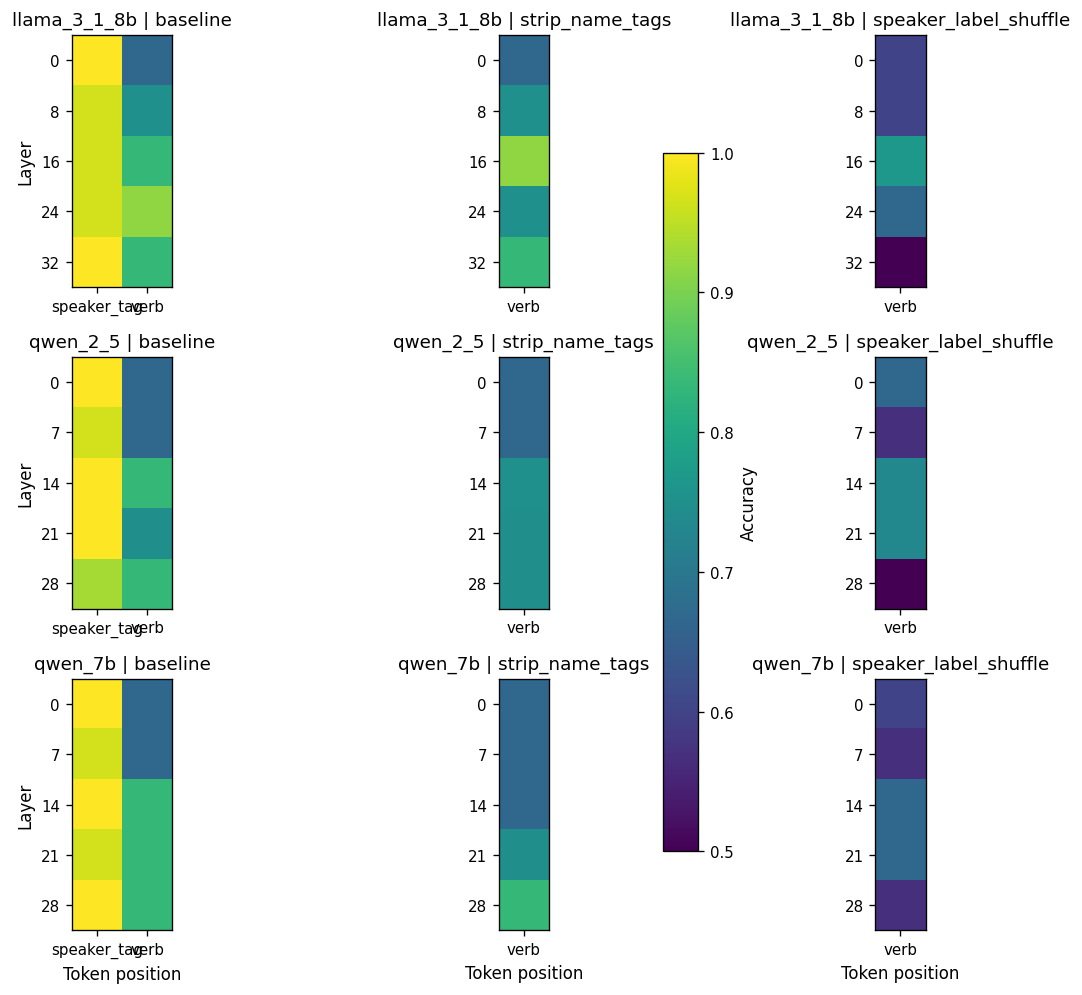

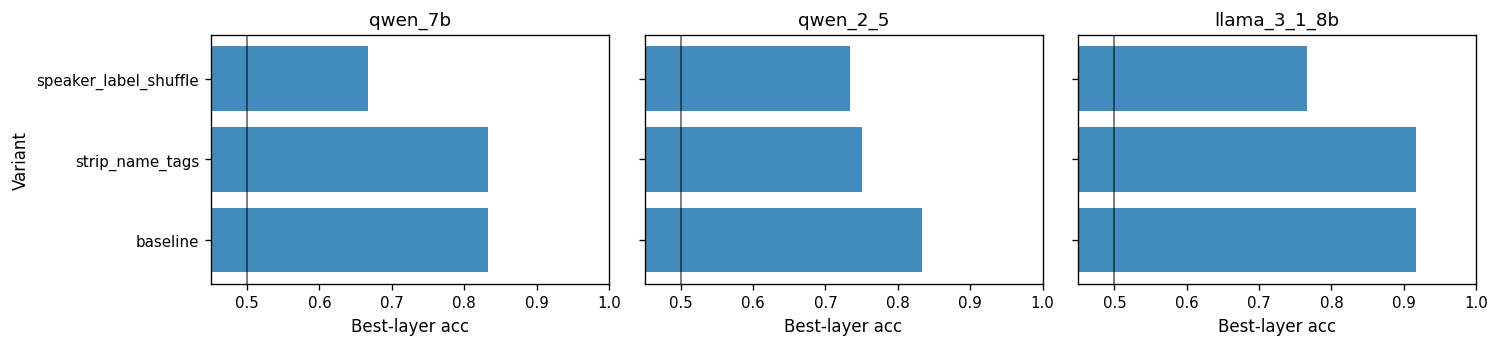

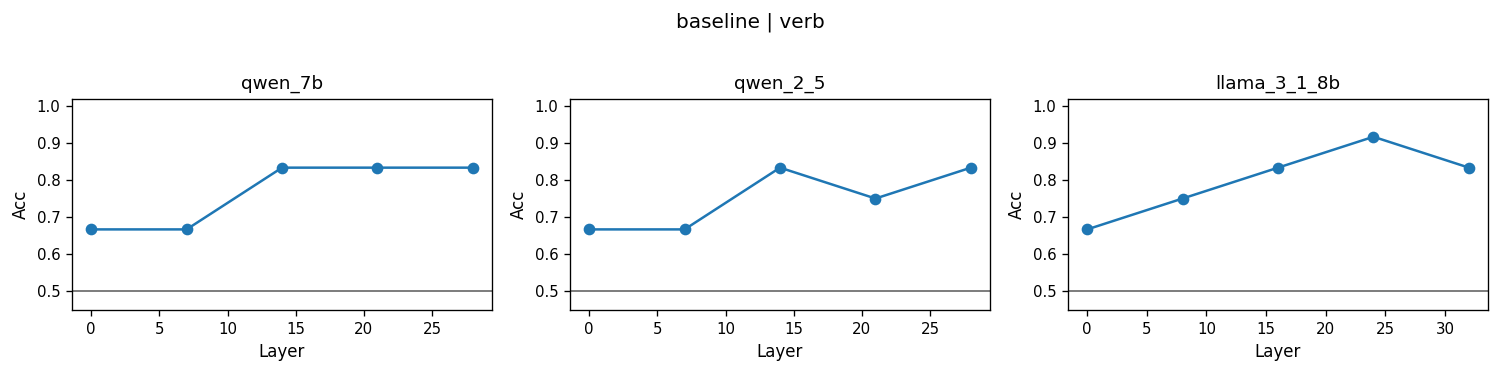

In [12]:
# Quick start examples

# 1) Grid of heatmaps across models for key variants
plot_heatmap_grid(
    variants=["baseline", "strip_name_tags", "speaker_label_shuffle"],
    models=models,
)

# 2) Best-layer bars for a position (one subplot per model)
plot_best_layer_grid(position="verb", variants=["baseline", "strip_name_tags", "speaker_label_shuffle"]) 

# 3) Layer curves for a fixed variant+position across models
plot_layercurve_grid(variant="baseline", position="verb")